In [1]:
import yfinance as yf
from datetime import datetime

In [2]:
# pharma companies used for training
pharma_list = ['BIIB', 'JNJ', 'PFE', 'ABBV']
# end time 
end = datetime.now()
start = datetime(end.year-5, end.month, end.day)

In [3]:
companies = {company : yf.download(company, start=start, end=end) for company in pharma_list}
companies

/Users/brad/.local/share/virtualenvs/guidelight-Popvxsqg/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/brad/.local/share/virtualenvs/guidelight-Popvxsqg/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/brad/.local/share/virtualenvs/guidelight-Popvxsqg/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.

{'BIIB':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-03-04  335.600006  336.570007  324.440002  327.260010  327.260010   
 2019-03-05  327.750000  330.119995  325.040009  326.869995  326.869995   
 2019-03-06  327.489990  328.410004  317.839996  317.970001  317.970001   
 2019-03-07  317.109985  318.000000  314.179993  315.290009  315.290009   
 2019-03-08  312.290009  313.329987  305.899994  307.929993  307.929993   
 ...                ...         ...         ...         ...         ...   
 2024-02-27  223.720001  224.869995  220.199997  223.940002  223.940002   
 2024-02-28  222.250000  224.119995  221.000000  221.740005  221.740005   
 2024-02-29  221.759995  224.000000  216.699997  216.990005  216.990005   
 2024-03-01  217.460007  222.020004  215.350006  220.949997  220.949997   
 2024-03-04  221.169998  222.919998  219.759995  221.020004  221.020004   
 
              V

In [4]:
from torch import nn
import torch

In [5]:
import seaborn as sns

<Axes: xlabel='Date', ylabel='Adj Close'>

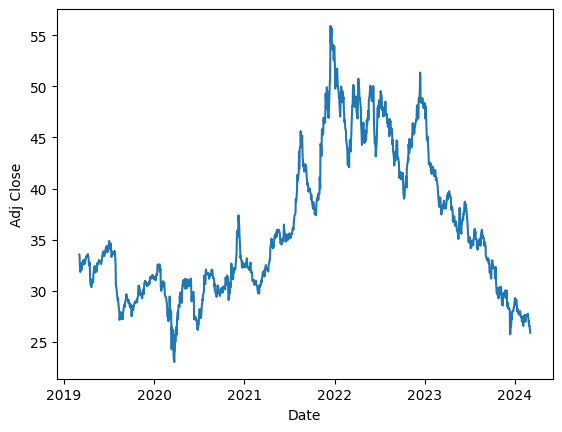

In [6]:
pfe = companies["PFE"]["Adj Close"]
sns.lineplot(data=pfe)

In [7]:
def robust_scale(data: torch.Tensor, axis: int = 0):
	IQR3 = torch.quantile(data, 0.75, dim=axis, keepdims=True)
	IQR1 = torch.quantile(data, 0.25, dim=axis, keepdims=True)
	return (data - torch.median(data)) / (IQR3 - IQR1)

In [8]:
# scale the data
scaled = robust_scale(torch.tensor(pfe.values).float())

In [9]:
train_size = int(0.8 * len(scaled))
train_data, test_data = torch.split(scaled, [train_size, len(scaled) - train_size])

window_size = 60
# time window
train_x = train_data.unfold(0, window_size, 1)

# actual resulte
train_y = train_data[window_size:]

In [10]:
#A simple demo for LSTM for stock prediction 


class StockLSTM(nn.Module):
	def __init__(self):
		super(StockLSTM, self).__init__()
		# utilizing 3 layers of LSTM
		self.lstms = nn.ModuleList([
            nn.LSTM(128, hidden_size=64, batch_first=True),
            nn.LSTM(64, hidden_size=64, batch_first=True),
            nn.LSTM(64, hidden_size=16, batch_first=True)  # Ensure consistency in input_size
        ])
		self.dropouts = nn.ModuleList([nn.Dropout(0.5) for _ in range(2)])

		self.linear = nn.Linear(16, 1)
		
	
	def forward(self,x):
		
		# since we would only need the last output of the LSTM
		
		for i in range(len(self.lstms)):
			x, _ = self.lstms[i](x)
			if i < len(self.dropouts):
				x = self.dropouts[i](x)
		x = x[-1:]
		x = self.linear(x)
		
		return x
	
	
	def train_loop(self, train_x, train_y, val_x, val_y):
		# chose the adam optimizer for prediction
		optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
		# currently using MSE loss function to fit the model ()
		loss_fn = nn.MSELoss()

		# training the model for 100 epochs
		for epoch in range(150):
			# set to training mode
			self.train()

			# zero the gradients otherwise they would accumulate
			optimizer.zero_grad()
			pred = self(train_x)
			loss = loss_fn(pred, train_y)
			loss.backward()
			optimizer.step()


			# set to evaluation mode
			self.eval()
			with torch.no_grad():  # Inference mode, gradients not computed
				val_pred = self(val_x)
				val_loss = loss_fn(val_pred, val_y)
			
			print(f'Epoch {epoch} loss: {loss.item()}', f'Validation loss: {val_loss.item()}')




In [11]:
model = StockLSTM()
model.train_loop(train_x, train_y, train_x, train_y)


# test the model
test_x = test_data.unfold(0, window_size, 1)
test_y = test_data[window_size:]
# set to evaluation mode
model.eval()

/Users/brad/.local/share/virtualenvs/guidelight-Popvxsqg/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([948])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss: 0.5685439109802246 Validation loss: 0.46274125576019287
Epoch 1 loss: 0.4627636671066284 Validation loss: 0.4707036316394806
Epoch 2 loss: 0.4627451002597809 Validation loss: 0.4730422794818878
Epoch 3 loss: 0.49640294909477234 Validation loss: 0.47057369351387024
Epoch 4 loss: 0.4720577597618103 Validation loss: 0.47385117411613464
Epoch 5 loss: 0.4631458520889282 Validation loss: 0.47186368703842163
Epoch 6 loss: 0.48420825600624084 Validation loss: 0.46386605501174927
Epoch 7 loss: 0.4655618667602539 Validation loss: 0.4639333486557007
Epoch 8 loss: 0.46352294087409973 Validation loss: 0.4732264280319214
Epoch 9 loss: 0.46611618995666504 Validation loss: 0.4802895486354828
Epoch 10 loss: 0.47172224521636963 Validation loss: 0.47624844312667847
Epoch 11 loss: 0.47439900040626526 Validation loss: 0.46734869480133057
Epoch 12 loss: 0.49548211693763733 Validation loss: 0.4627859890460968
Epoch 13 loss: 0.46327975392341614 Validation loss: 0.46740204095840454
Epoch 14 loss:

StockLSTM(
  (lstms): ModuleList(
    (0): LSTM(128, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
    (2): LSTM(64, 16, batch_first=True)
  )
  (dropouts): ModuleList(
    (0-1): 2 x Dropout(p=0.5, inplace=False)
  )
  (linear): Linear(in_features=16, out_features=1, bias=True)
)